In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
#import pydotplus
#import io

import seaborn.apionly as sns
sns.set_style("whitegrid", {'grid.color': '0.9','grid.linestyle': u'--'})
sns.set_context("poster")

%matplotlib inline
import json

from datetime import datetime 

import warnings
warnings.filterwarnings("ignore")

In [2]:
def chunkload(data_json, n_size):
    url_json = 'C:/Users/liche/Desktop/Document/Harvard Extension School/Project/dataset/%s.json' %(data_json)
    urlw_json = 'C:/Users/Public/Documents/Harvard/Project/dataset/%s.json' %(data_json)
    
    df_data = pd.DataFrame()
    
    for chunk in pd.read_json(url_json, lines = True, chunksize = n_size):
        df_data = df_data.append(chunk)
        
    return(df_data)

### Load business, review, user dataset

In [3]:
### load business.json
df_business = chunkload( 'business', 5000 )
print('business.json loaded up')

### load checkin.json
#df_checkin = chunkload( 'checkin', 5000 )
#print('checkin.json loaded up')

### load review.json
df_review = chunkload( 'review', 500000)
print('review.json loaded up')

### load tip.json
#df_tip = chunkload( 'tip', 500000)
#print('tip.json loaded up')

### load user.json
df_user = chunkload( 'user', 500000)
print('user.json loaded up')

business.json loaded up
review.json loaded up
user.json loaded up


### Merge three dataset together and only select restaurant

In [ ]:
### Merge business data with review data

# Timer
print('time: {}'.format(datetime.now().strftime("%X")))
bus_col_list = ['business_id','review_count', 'stars','categories','attributes','city', 'state']

### Select restaurant
df_restaurant = df_business[bus_col_list][df_business['categories'].apply(lambda x: 'Restaurants' in x)]

review_list = ['review_id','user_id','stars','date','business_id']
df_bus_rev =pd.merge(df_review[review_list],df_restaurant, on =['business_id'])

df_bus_rev.columns = ['review_id', 'user_id', 'review_stars', 'date', 'business_id',
       'review_count', 'business_stars', 'categories', 'attributes','city', 'state']

#Timer
print('time: {}'.format(datetime.now().strftime("%X")))

df_bus_rev.head();

In [ ]:
### Merger user data with review data
print('time: {}'.format(datetime.now().strftime("%X")))

user_col_list = ['user_id','average_stars','review_count','useful','yelping_since']
df_bus_rev_user =pd.merge(df_bus_rev, df_user[user_col_list], on =['user_id'] )
df_bus_rev_user.columns = ['review_id', 'user_id', 'review_stars', 'date', 'business_id',
       'business_review_count', 'business_stars', 'categories', 'attributes','city', 'state', 
       'user_average_stars', 'user_review_count', 'useful', 'yelping_since']

print('time: {}'.format(datetime.now().strftime("%X")))

## Drop nan
df_bus_rev_user = df_bus_rev_user.dropna(axis=1, how='any')

print('time: {}'.format(datetime.now().strftime("%X")))

In [6]:
#### Delete unused variable to free up memory
del df_user
del df_review

In [7]:
#### Add year column
df_bus_rev_user['Year'] =df_bus_rev_user['date'].dt.year

##### Add the years of yelping for user 
df_bus_rev_user['yelping_years'] = (2018 - pd.to_datetime(df_bus_rev_user['yelping_since']).dt.year)

#### Predictors are the difference of using rating and average and the difference of business rating and average
df_bus_rev_user['user_review_bias'] =  df_bus_rev_user['user_average_stars'] - df_bus_rev_user['user_average_stars'].mean()
df_bus_rev_user['business_review_bias'] =  df_bus_rev_user['business_stars'] - df_bus_rev_user['business_stars'].mean()

In [ ]:
df_bus_rev_user.head();

### Split Train and Test

In [8]:
#function to split into training and test sets
def split_train_test(df):
    np.random.seed(9001)
    
    msk = np.random.rand(len(df)) < 0.5
    data_train = df[msk]
    data_test = df[~msk]
    return data_train, data_test

df_bus_rev_user_train ,df_bus_rev_user_test = split_train_test(df_bus_rev_user)

### Build EDA Chart

In [9]:
##### User review star for business
star_count =df_bus_rev_user_train.groupby(['review_stars'], as_index=False)['business_id'].count()
star_count = star_count.rename(columns = {'review_stars': 'review_stars',  'business_id': 'star_count'})

#### Aggregate business star
business_star_count =df_bus_rev_user_train.groupby(['business_stars'], as_index=False)['business_id'].count()
business_star_count = business_star_count.rename(columns = {'business_stars': 'business_stars'
                                                            ,  'business_id': 'business_star_count'})

#### Aggregate business star vs business review count
business_review_count =df_bus_rev_user_train.groupby(['business_stars'], as_index=False)['business_review_count'].mean()
business_review_count = business_review_count.rename(columns = {'business_stars': 'business_stars'
                                                            ,  'business_review_count': 'business_review_count_average'})

#### Average business rating by year
#df_bus_rev_user_train['Year'].value =df_bus_rev_user_train['date'].dt.year
business_rating_year =df_bus_rev_user_train.groupby(['Year'], as_index=False)['business_stars'].mean()
business_rating_year = business_rating_year.rename(columns = {'Year': 'Year'
                                                            ,  'business_stars': 'business_stars_average'})

#### Aggregate business star vs state
business_star_state =df_bus_rev_user_train.groupby(['state'], as_index=False)['business_id'].count()
business_star_state = business_star_state.rename(columns = {'state': 'state'
                                                            ,  'business_id': 'business_id_count'})

business_star_state = business_star_state[business_star_state['state'].apply(lambda x: x in 
                                ['FL', 'WA', 'NY', 'NE', 'ON', 'SC', 'IL', 'NC', 'OH', 'PA', 'NV', 'WI', 'AZ'
                                 , 'NI', 'QC', 'ST', 'CA', 'VT', 'AL'])]

business_star_state = business_star_state.sort_values(by = 'business_id_count').reset_index(drop=True)
### Set x axis
x_state = np.arange(len(business_star_state['state']))


#### Average user rating by the number of yelping years
user_rating_useful =df_bus_rev_user_train.groupby(['review_stars'], as_index=False)['useful'].count()
user_rating_useful = user_rating_useful.rename(columns = {'Year': 'Year'
                                                            ,  'useful': 'useful_review_count'})

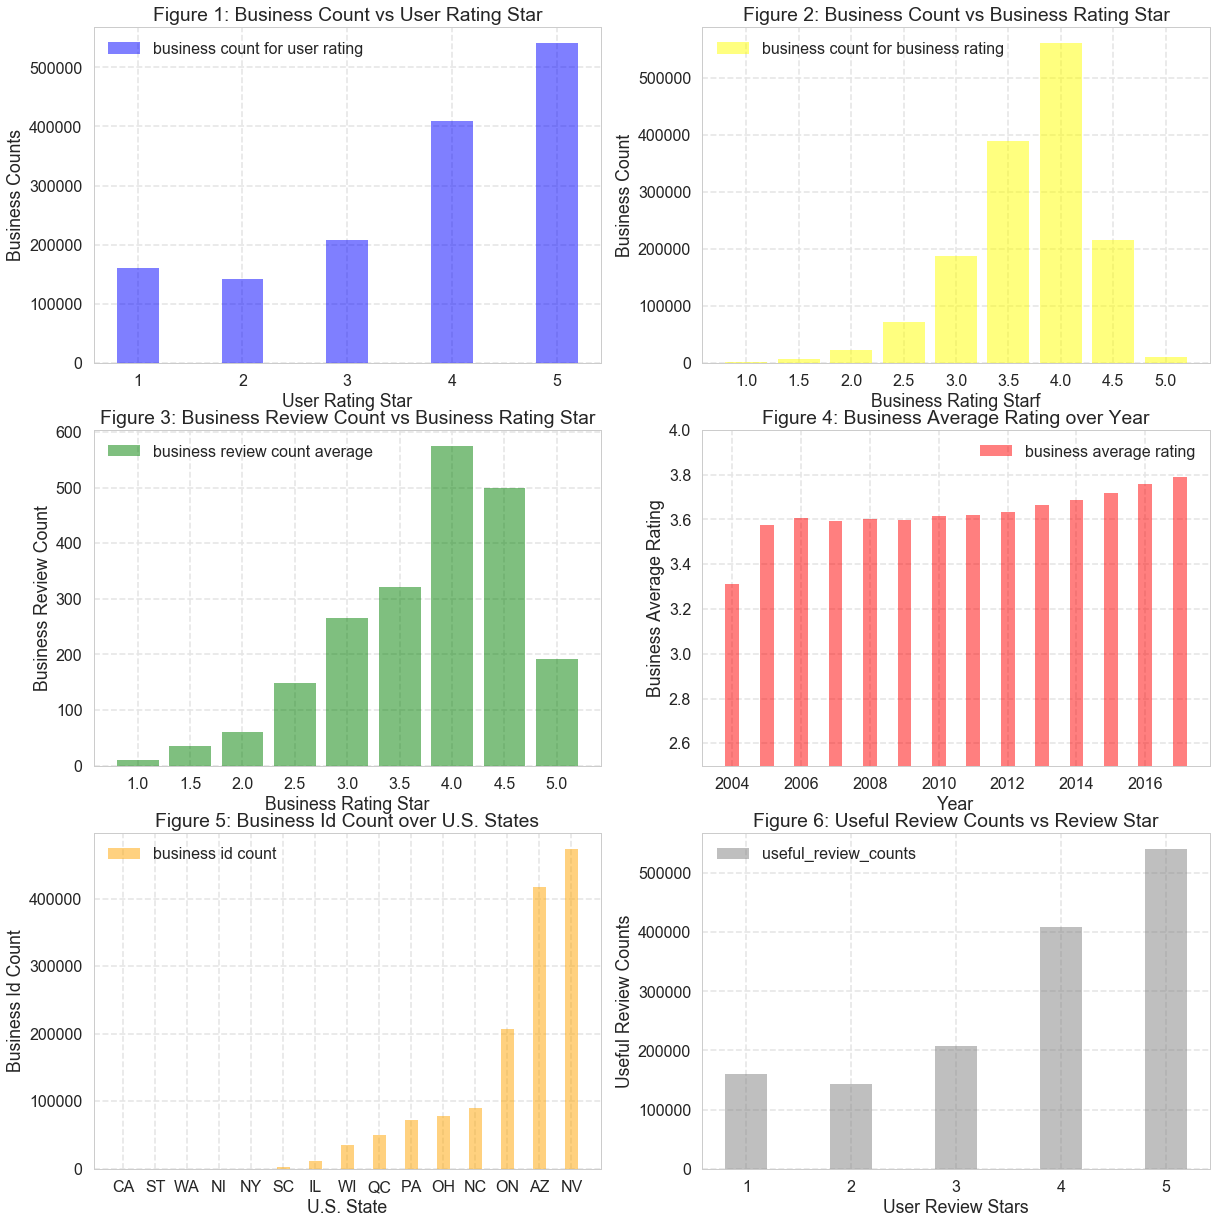

In [10]:
#### Plot chart for review star for business id
fig, ax = plt.subplots(3,2, figsize = (20,21));
ax = ax.ravel()

##### User review star vs business count
ax[0].bar(star_count['review_stars'], star_count['star_count'], 0.4, color = 'blue'
    , alpha = 0.5, label = 'business count for user rating');
ax[0].set_xlabel('User Rating Star');
ax[0].set_ylabel('Business Counts');
ax[0].set_title('Figure 1: Business Count vs User Rating Star');
ax[0].legend(loc = 'best');

#### Business Count vs Business Rating Star
ax[1].bar(business_star_count['business_stars'], business_star_count['business_star_count'], 0.4, color = 'yellow'
    , alpha = 0.5, label = 'business count for business rating');
ax[1].set_xlabel('Business Rating Starf');
ax[1].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);
ax[1].set_ylabel('Business Count');
ax[1].set_title('Figure 2: Business Count vs Business Rating Star');
ax[1].legend(loc = 'best');

#### Business Review Count vs Business Rating Star
ax[2].bar(business_review_count['business_stars'], business_review_count['business_review_count_average'], 0.4, color = 'green'
    , alpha = 0.5, label = 'business review count average');
ax[2].set_xlabel('Business Rating Star');
ax[2].set_xticks([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]);
ax[2].set_ylabel('Business Review Count');
ax[2].set_title('Figure 3: Business Review Count vs Business Rating Star');
ax[2].legend(loc = 'best');

#### Business Average Rating over Year
ax[3].bar(business_rating_year['Year'], business_rating_year['business_stars_average'], 0.4, color = 'red'
    , alpha = 0.5, label = 'business average rating');
ax[3].set_xlabel('Year');
ax[3].set_ylim([2.5,4]);
ax[3].set_ylabel('Business Average Rating');
ax[3].set_title('Figure 4: Business Average Rating over Year');
ax[3].legend(loc = 'best');

### Business Id Count over U.S. States
ax[4].bar(x_state, business_star_state['business_id_count'], 0.4, color = 'orange'
          , alpha = 0.5, label = 'business id count');
ax[4].set_xlabel('U.S. State');
ax[4].set_xticks(x_state);
ax[4].set_xticklabels(business_star_state['state'].values);
#ax[4].set_ylim([2.5,4.5]);
ax[4].set_ylabel('Business Id Count');
ax[4].set_title('Figure 5: Business Id Count over U.S. States');
ax[4].legend(loc = 'best');

### Useful Review Counts vs Review Star
ax[5].bar(user_rating_useful['review_stars'], user_rating_useful['useful_review_count'], 0.4, color = 'grey'
    , alpha = 0.5, label = 'useful_review_counts');
ax[5].set_xlabel('User Review Stars');
ax[5].set_ylabel('Useful Review Counts');
ax[5].set_title('Figure 6: Useful Review Counts vs Review Star');
ax[5].legend(loc = 'best');
